In [1]:
import time
import nest
import network
import addons
import helpers
import numpy as np
import pandas as pd 
from network_params import net_dict
from sim_params import sim_dict
from stimulus_params import stim_dict

time_start = time.time()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Computing Synchrony

Measurement of different Synchrony quantities from the spike times obtained in the simulation. 

Measurements:

    - Synchrony (as defined by Potjans Diesmann)

    - Second Synchrony measurement (to make sure there are no bias)

    - Irregularity (CV ISI as defined by Potjans Diesmann)
    
    - LvR (as defined by pronold, 2024)

Irregularity and LvR will have a singular value for each population, and a pdf for each population, aswell

In [2]:
name = addons.analysis_dict["name"]

/home/hyc_1/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning:invalid value encountered in divide


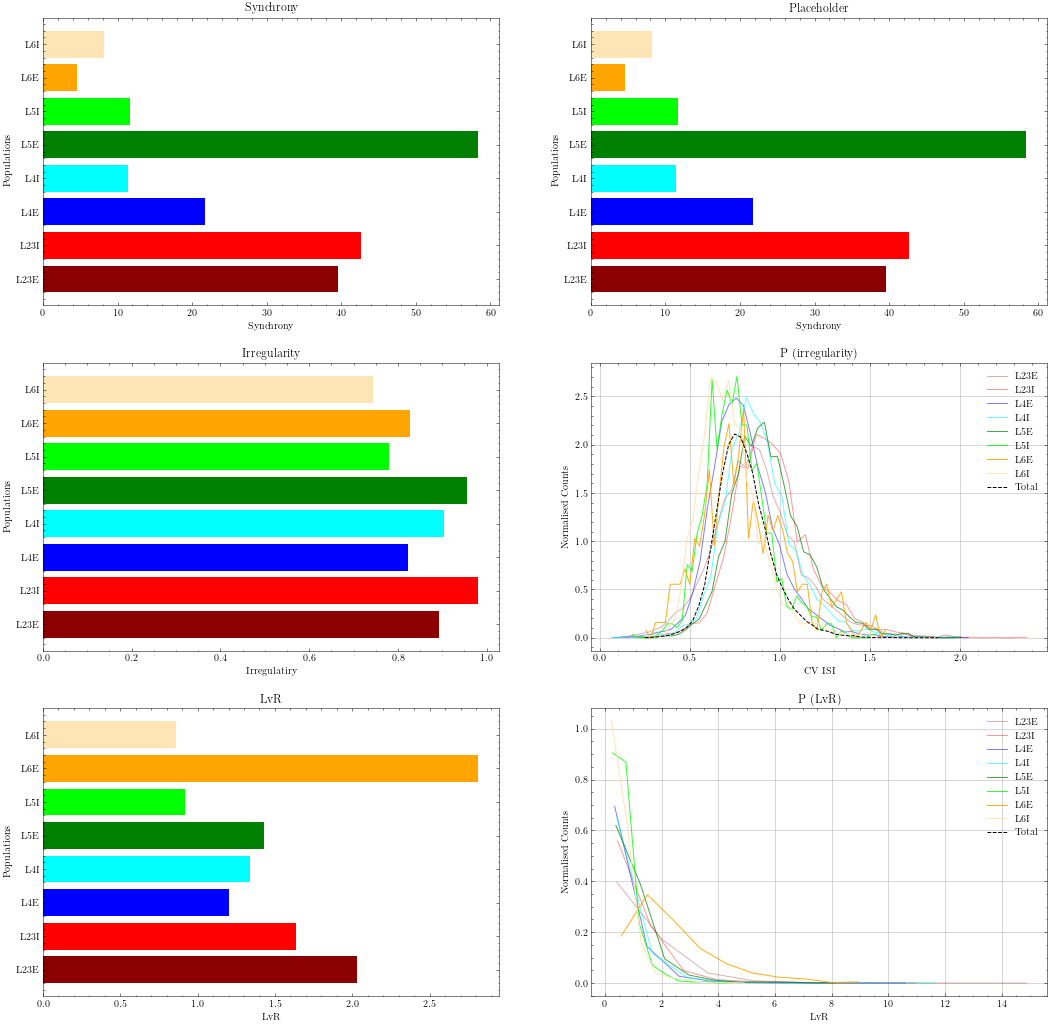

In [3]:
synchrony_pd, irregularity, irregularity_pdf, lvr, lvr_pdf, times_s = addons.analyse_synchrony()
addons.plot_synchrony(synchrony_pd,irregularity,irregularity_pdf,lvr,lvr_pdf)

In [4]:
np.savetxt(name + "synchrony.dat",synchrony_pd)
np.savetxt(name + "irregularity.dat",irregularity)
np.savetxt(name + "lvr.dat",lvr)

for i in irregularity_pdf:
    np.savetxt(name + "irregularities/irregularity_"+str(i)+".dat",irregularity_pdf[i])
for i in lvr_pdf:
    np.savetxt(name + "lvrs/lvr_"+str(i)+".dat",lvr_pdf[i])
for i in times_s:
    np.savetxt(name + "times/time_"+str(i)+".dat",times_s[i])


### Computing Firing Rates

Measurement of different Firing Rates quantities from the spike times obtained in the simulation. 

Measurements:

    - Firing rate histogram and pdf per population
    
    - Color map of the evolution of firing rates as a function of time

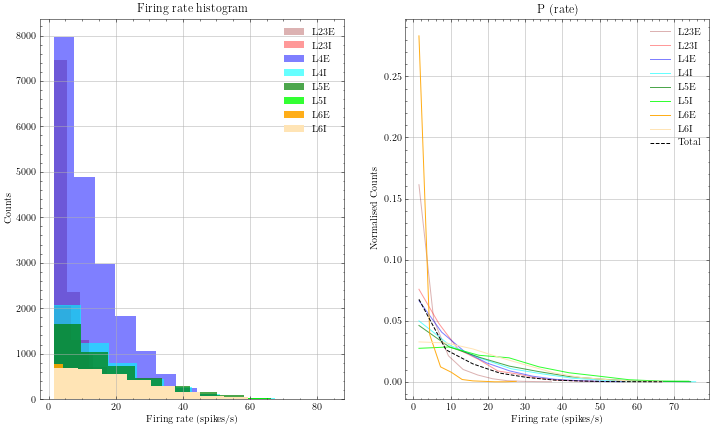

In [5]:
spike_rates = addons.analyse_firing_rates()
addons.plot_firing_rates(spike_rates)

In [6]:
for i in spike_rates:
    np.savetxt(name + "spike_rates/spike_rate_"+str(i)+".dat",spike_rates[i])